## **Environment Setup**
Run all when initiating session

In [ ]:
# retrieve config file, if using colab (nothing should happen if you use Windows)
!cp './drive/My Drive/Live Workspace/generative-facial-cosmetics/encoder_engineering/config.py' '.'
!mkdir data
!cp -a './drive/My Drive/Live Workspace/generative-facial-cosmetics/encoder_engineering/data/' '.'
!mkdir models
!cp -a './drive/My Drive/Live Workspace/generative-facial-cosmetics/encoder_engineering/models/' '.'
!mkdir technical
!cp -a './drive/My Drive/Live Workspace/generative-facial-cosmetics/encoder_engineering/technical/' '.'
!mkdir trainers
!cp -a './drive/My Drive/Live Workspace/generative-facial-cosmetics/encoder_engineering/trainers/' '.'
!mkdir utils
!cp -a './drive/My Drive/Live Workspace/generative-facial-cosmetics/encoder_engineering/utils/' '.'

In [1]:
from config import *                            # config.py
from matplotlib import pyplot as plt 
import os
%matplotlib inline

## **GCS Integration**
Run all when initiating session

In [2]:
if isWindows():
  import utils.gcs_windows as gcs 
elif isColab():
  import utils.gcs_colab as gcs
else:
  raise NotImplementedError('OS is not supported yet')

if isColab():
  gcs.init()
# no need of buckets for this project

## **Model Environment Setup**

In [3]:
### tf-side debug ###
# more info: https://github.com/tensorflow/tensorflow/issues/29931
import tensorflow as tf
temp = tf.zeros([2, 16, 16, 3])  # Or tf.zeros
tf.keras.applications.vgg16.preprocess_input(temp)
print('')

In [4]:
from technical.accelerators import strategy
from data.pipeline import *
from trainers.cnn import train, load_checkpoint
from models.encoder import Encoder
from utils.generator_loading_utils import load_generator_checkpoint

Running on CPU
Number of accelerators (cores):  1


In [5]:
encoder = Encoder(strategy)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 360, 360, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 360, 360, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 360, 360, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 180, 180, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 180, 180, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 180, 180, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 90, 90, 128)       0     

In [6]:
##### Load saved models here #####
RUN = False
# Warning, using this format on colab may cause the "'NoneType' object has no attribute 'get'" bug
if RUN:
  last_epoch = 0
  encoder.load(strategy=strategy, fname="encoder" + "-e_" + str(last_epoch))
else:
  print("Running switch for this cell is off, skipping")

Running switch for this cell is off, skipping


In [7]:
##### Load saved models here (checkpoint) #####
RUN = False
if RUN:
  load_checkpoint(encoder, strategy)
else:
  print("Running switch for this cell is off, skipping")

Running switch for this cell is off, skipping


In [8]:
##### Create and load saved generator here (checkpoint) #####
# please put generator's saved checkpoint in OUTPUT/generator_checkpoints (GCS for colab)
RUN = True
if RUN:
  generator = load_generator_checkpoint(strategy)
  print(generator)
else:
  print("Running switch for this cell is off, skipping")

r.layer_with_weights-1.kernel


In [9]:
LATENT_SIZE = Encoder.LATENT_SIZE 
IMAGE_SHAPE = Encoder.IMAGE_SHAPE
IMAGE_SIZE = [IMAGE_SHAPE[0], IMAGE_SHAPE[0]]
print("Latent size: " + str(LATENT_SIZE))
print("Image shape: " + str(IMAGE_SHAPE))

Latent size: 256
Image shape: (360, 360, 3)


In [10]:
##### Prepare dataset #####
training_dataset, validation_dataset = get_dataset(generator, strategy, batch=True)

## **Pre-Train Testing**

In [ ]:
noise = tf.random.normal([1,LATENT_SIZE])
print(noise)

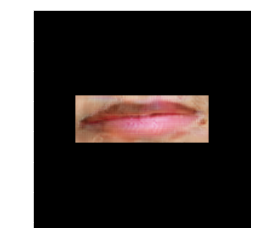

In [14]:
## generator output
image = generator.model(noise, training=False)[0][:,:,:3]
plt.imshow(image)

In [15]:
## encoder output
import numpy as np
encoded = encoder.model(np.expand_dims(preprocess(image, None)[0], 0))
print(encoded)

tf.Tensor(
[[-2.3715928   1.2900784  -0.2639477  -0.8441865  -1.610278   -1.1442301
   0.861206    0.41742468  0.16340393 -0.8675007  -2.2538972   0.2500255
  -2.5133653  -0.2390111  -3.398319    1.1762683   1.128331    1.6337076
  -1.550979    1.6503782  -2.6654384   2.1090794  -3.2213526  -0.01389049
   2.2195113   0.8991954  -1.0227251  -2.1507     -0.40129226  0.837788
  -2.4442885  -1.6533624   0.46064377 -0.5201223   0.9399195   0.6541047
   1.8833767   2.382299   -1.5774412   0.06154718 -2.8954947  -0.10871728
  -0.03315284 -0.35345614  0.43823218 -0.5960902  -2.0090463   1.4105016
   1.3653083   3.2789993  -3.4756227  -0.5449326   0.40200222  1.6568503
  -0.9749249   1.5410317  -0.6955669   1.7870278  -0.5696914  -0.3014626
   2.64993    -3.286461   -1.7587732  -0.5419969  -2.7055612  -0.23090091
   1.1113237   1.1662073  -0.15421408 -1.4538314   1.6957064   1.0635251
  -2.0735958  -0.26140672  0.41812503 -1.9223458   1.9689847  -1.9162835
  -2.3248475  -1.6311727   1.0996058  

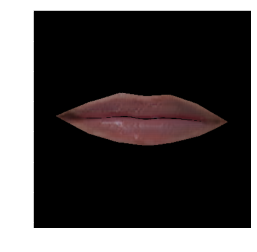

In [16]:
## regeneration
image = generator.model(encoded, training=False)[0]
plt.imshow(image)

## **Training**

In [11]:
EPOCHS = 200

if isColab():                   # some colab's tpu side bug
  import numpy as np
  np.rank = np.ndim
train(encoder, training_dataset, validation_dataset, EPOCHS, strategy, restore_checkpoint=False)

ValueError: The `batch_size` argument must not be specified for the given input type. Received input: <ParallelMapDataset shapes: (360, 360, 3), types: tf.float32>, batch_size: 32

## **Saving**

In [13]:
encoder.save(0, strategy)

INFO:tensorflow:Assets written to: .\outputs\saved_models\current\generator-p_2-e_0\assets
INFO:tensorflow:Assets written to: .\outputs\saved_models\current\discriminator-p_2-e_0\assets


## **Testing**

[[-8.374135]]


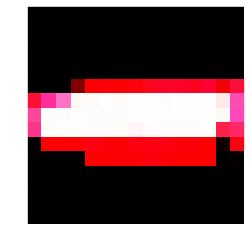

In [8]:
noise = tf.random.normal([1,LATENT_SIZE])
image = generator.model(noise, training=False)
plt.imshow(image[0])
print(discriminator.model(image, training=False).numpy())

## **Experiments**
Just a playground for trying out codes, nothing related at all, do not execute

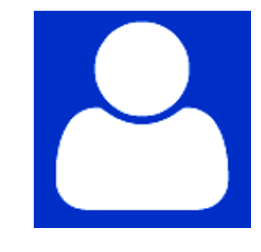

In [143]:
### just code testing

import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt 
import os
from PIL import Image
%matplotlib inline

fbytes = tf.io.read_file('avatar.png')
image = tf.image.decode_png(fbytes, channels=4)
max_resize = 0.5
random_scale = max_resize + np.random.rand()*(1 - max_resize)
image = tf.image.central_crop(image, random_scale)
image = Image.fromarray(image.numpy())
image = image.resize((206, 206))
image = tf.convert_to_tensor(np.array(image))
plt.imshow(image)

0.8249300690690824